In [98]:
import pandas as pd
import urllib

import numpy as np

import json

from tqdm.autonotebook import tqdm

#%matplotlib inline

tqdm.pandas()

import dask.dataframe as dd

# from dask.multiprocessing import get
from dask.diagnostics import ProgressBar

from datetime import datetime
import matplotlib.pyplot as plt

from IPython.display import display
import requests

try: 
    import seaborn as sbn
except ModuleNotFoundError: 
    print("Seaborn not installed, limiting plotting quality")

Seaborn not installed, limiting plotting quality


# Functions

In [99]:
ws_hostname = "172.27.0.64:4001" # bePelias hostname:port

street_field  =  "streetName"
housenbr_field = "houseNumber"
postcode_field = "postCode"
city_field  =    "postName"

filename = "data.csv" # A csv file with as header "streetName,houseNumber,postCode,postName"

In [100]:
def call_ws(addr_data, mode="advanced"):
    t = datetime.now()
    
    if isinstance(addr_data, pd.Series):
        addr_data = addr_data.to_dict()
        
    
    addr_data["mode"]=mode       
    addr_data["withPeliasResult"]=True
    try: 
        r = requests.get(
        f'http://{ws_hostname}/REST/bepelias/v1/geocode',
            params=addr_data)
        

    except Exception as e:
        print("Exception !")
        print(addr_data)
        print(e)
        raise e
        
    if r.status_code == 204:
        print("No result!")
        print(addr_data)
        print(r.text)
        return
    elif r.status_code == 400:
        print("Argument error")
        print(r.text)
    elif r.status_code == 200:
        try:
            res = json.loads(r.text)
            res["time"] = (datetime.now() - t).total_seconds()
        except ValueError as ve:

            print("Cannot decode result:")
            print(ve)
            print(r.text)
            return r.text
        return res
    else: 
        print(f"Unknown return code: {r.status_code} ")
        print(r.text)



In [101]:
def call_unstruct_ws(address, mode="advanced"):
    t = datetime.now()
    
    addr_data = {"address": address}
    
        
    
    addr_data["mode"]=mode       
    addr_data["withPeliasResult"]=True
    try: 
        r = requests.get(
        f'http://{ws_hostname}/REST/bepelias/v1/geocode/unstructured',
            params=addr_data)
        

    except Exception as e:
        print("Exception !")
        print(addr_data)
        print(e)
        raise e
        
    if r.status_code == 204:
        print("No result!")
        print(addr_data)
        print(r.text)
        return
    elif r.status_code == 400:
        print("Argument error")
        print(r.text)
    elif r.status_code == 200:
        try:
            res = json.loads(r.text)
            res["time"] = (datetime.now() - t).total_seconds()
        except ValueError as ve:

            print("Cannot decode result:")
            print(ve)
            print(r.text)
            return r.text
        return res
    else: 
        print(f"Unknown return code: {r.status_code} ")
        print(r.text)



In [102]:
def call_ws_by_id(best_id): 
    t = datetime.now()
    
    if best_id is None:
        return None
       
    try: 
        url = f'http://{ws_hostname}/REST/bepelias/v1/id/{urllib.parse.quote_plus(urllib.parse.quote_plus(best_id))}'
        r = requests.get(url)
        

    except Exception as e:
        print("Exception !")
        print(best_id)
        print(e)
        raise e
        
    if r.status_code == 204:
        # print("No result!")
        # print(addr_data)
        # print(r.text)
        return
    elif r.status_code == 400:
        print("Argument error")
        print(r.text)
    elif r.status_code == 200:
        try:
            res = json.loads(r.text)
        except ValueError as ve:

            print("Cannot decode result:")
            print(ve)
            print(r.text)
            return r.text
        except AttributeError as ae:
            print(ae)
            print(type(r.text))
            print(r.text)
        return res
    else: 
        print(f"Unknown return code: {r.status_code} ")
        print(r.text)



In [103]:
def call_ws_search_city(postcode=None, postname=None):
    t = datetime.now()
    
    data = {"postCode": postcode,
           "postName": postname,
           "raw":True
           }
    
    try: 
        r = requests.get(
        f'http://{ws_hostname}/REST/bepelias/v1/searchCity',
            params=data)

    except Exception as e:
        print("Exception !")
        print(e)
        raise e
        
    if r.status_code == 204:
        # print("No result!")
        # print(addr_data)
        # print(r.text)
        return
    elif r.status_code == 400:
        print("Argument error")
        print(r.text)
    elif r.status_code == 200:
        try:
            res = json.loads(r.text)
            # res["time"] = (datetime.now() - t).total_seconds()
        except ValueError as ve:

            print("Cannot decode result:")
            print(ve)
            print(r.text)
            return r.text
        except AttributeError as ae:
            print(ae)
            print(type(r.text))
            print(r.text)
        return res
    else: 
        print(f"Unknown return code: {r.status_code} ")
        print(r.text)



In [104]:
def call_ws_reverse(lat=None, lon=None): #lg = "en,fr,nl"
    t = datetime.now()
    
    data = {"lat": lat,
           "lon": lon,
           "radius":0.01,
           "size":1
           }
    
    try: 
        r = requests.get(
        f'http://{ws_hostname}/REST/bepelias/v1/reverse',
            params=data)

    except Exception as e:
        print("Exception !")
        print(e)
        raise e
        
    if r.status_code == 204:
        # print("No result!")
        # print(addr_data)
        # print(r.text)
        return
    elif r.status_code == 400:
        print("Argument error")
        print(r.text)
    elif r.status_code == 200:
        try:
            res = json.loads(r.text)
            # res["time"] = (datetime.now() - t).total_seconds()
        except ValueError as ve:

            print("Cannot decode result:")
            print(ve)
            print(r.text)
            return r.text
        except AttributeError as ae:
            print(ae)
            print(type(r.text))
            print(r.text)
        return res
    else: 
        print(f"Unknown return code: {r.status_code} ")
        print(r.text)



In [105]:
def get(dct, keys):
    for k in keys:
        try: 
            if  dct is None:
                return None
                # print(init_dct)

            dct = dct[k]
        except KeyError :
            return None
        except IndexError:
            return None
    return dct

# Calls

## Single address calls

In [106]:
res=call_ws({
        street_field:   "Avenue Fonsny", \
         housenbr_field: "20",\
         city_field:     "Saint-Gilles",\
         postcode_field: "1060"})
res

{'self': 'http://172.27.0.64:4001/REST/bepelias/v1/geocode?streetName=Avenue+Fonsny&houseNumber=20&postName=Saint-Gilles&postCode=1060&mode=advanced&withPeliasResult=True',
 'items': [{'bestId': 'https://databrussels.be/id/address/219307/7',
   'street': {'name': {'fr': 'Avenue Fonsny', 'nl': 'Fonsnylaan'},
    'id': 'https://databrussels.be/id/streetname/4921/2'},
   'municipality': {'name': {'fr': 'Saint-Gilles', 'nl': 'Sint-Gillis'},
    'code': '21013',
    'id': 'https://databrussels.be/id/municipality/21013/14'},
   'postalInfo': {'name': {'fr': 'Saint-Gilles', 'nl': 'Sint-Gillis'},
    'postalCode': '1060'},
   'housenumber': '20',
   'status': 'current',
   'precision': 'address',
   'coordinates': {'lat': 50.83582, 'lon': 4.33844}}],
 'total': 1,
 'peliasRaw': {'geocoding': {'version': '0.2',
   'attribution': 'http://pelias_api:4000/attribution',
   'query': {'parsed_text': {'postalcode': '1060',
     'housenumber': '20',
     'street': 'Avenue Fonsny,'},
    'size': 10,
    

## Batch calls (row by row)

In [107]:
addresses = pd.read_csv(filename)
addresses

,streetName,houseNumber,postCode,postName
0,Dendermondsesteenweg,200,2830,Willebroek
1,Boulevard du Régent,47,1000,Bruxelles
2,Hauwaart,44,9700,Oudenaarde
3,Bruynebosstraat,40,3511,Hasselt
4,Steenwinkelstraat,583,2627,Schelle
...,...,...,...,...
995,Route de Marche,43,6940,Durbuy
996,Godfried van Leuvenlaan,8,1600,Sint-Pieters-Leeuw
997,Valleilaan,83,3290,Diest
998,Venusstraat,2,2000,Antwerpen


In [108]:
# addresses = addresses.sample(10000)

In [109]:
iter_per_sec_stats={}


### Simple way

In [110]:
addresses_seq = addresses.copy()

t = datetime.now()
addresses_seq["json"] = addresses_seq[[street_field, housenbr_field, postcode_field, city_field]].fillna("").progress_apply(call_ws,
                                                                mode="advanced", axis=1)
tot_time = (datetime.now() - t).total_seconds()

ips=addresses_seq.shape[0]/tot_time
iter_per_sec_stats["sequential"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")


addresses_seq

100%|██████████| 1000/1000 [00:39<00:00, 25.62it/s]

39.03 seconds, 25.62 it/s


,streetName,houseNumber,postCode,postName,json
0,Dendermondsesteenweg,200,2830,Willebroek,{'self': 'http://172.27.0.64:4001/REST/bepelia...
1,Boulevard du Régent,47,1000,Bruxelles,{'self': 'http://172.27.0.64:4001/REST/bepelia...
2,Hauwaart,44,9700,Oudenaarde,{'self': 'http://172.27.0.64:4001/REST/bepelia...
3,Bruynebosstraat,40,3511,Hasselt,{'self': 'http://172.27.0.64:4001/REST/bepelia...
4,Steenwinkelstraat,583,2627,Schelle,{'self': 'http://172.27.0.64:4001/REST/bepelia...
...,...,...,...,...,...
995,Route de Marche,43,6940,Durbuy,{'self': 'http://172.27.0.64:4001/REST/bepelia...
996,Godfried van Leuvenlaan,8,1600,Sint-Pieters-Leeuw,{'self': 'http://172.27.0.64:4001/REST/bepelia...
997,Valleilaan,83,3290,Diest,{'self': 'http://172.27.0.64:4001/REST/bepelia...
998,Venusstraat,2,2000,Antwerpen,{'self': 'http://172.27.0.64:4001/REST/bepelia...


In [111]:
addresses_seq["best_id"] = addresses_seq.json.apply(lambda r: get(r, ["items", 0, "bestId"]) or\
                                                              get(r, ["items", 0, "street", "id"]) or\
                                                              get(r, ["items", 0, "municipality", "id"]))

addresses_seq

,streetName,houseNumber,postCode,postName,json,best_id
0,Dendermondsesteenweg,200,2830,Willebroek,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/391785/202...
1,Boulevard du Régent,47,1000,Bruxelles,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://databrussels.be/id/address/164117/6
2,Hauwaart,44,9700,Oudenaarde,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1216986/20...
3,Bruynebosstraat,40,3511,Hasselt,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/30693367/2...
4,Steenwinkelstraat,583,2627,Schelle,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1167407/20...
...,...,...,...,...,...,...
995,Route de Marche,43,6940,Durbuy,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Address/177216/3
996,Godfried van Leuvenlaan,8,1600,Sint-Pieters-Leeuw,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/20196254/2...
997,Valleilaan,83,3290,Diest,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1994910/20...
998,Venusstraat,2,2000,Antwerpen,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1834258/20...


In [112]:
# Results with no address id
addresses_seq[addresses_seq.json.apply(lambda r: get(r, ["items", 0, "bestId"])).isnull()]

,streetName,houseNumber,postCode,postName,json,best_id
12,Rue du Panorama - ATHUS,28,6791,Aubange,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Streetname/7742084/2
45,Rue Marconi,143,1190,Forest,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://databrussels.be/id/streetname/113/2
47,Kattenstraat,33,8800,Roeselare,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/straatnaam/58052...
48,Kaardeloodstraat,6,9400,Ninove,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/straatnaam/63526...
52,Rue du Tige,250B,4590,Ouffet,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Streetname/7726095/1
...,...,...,...,...,...,...
959,"Neuvillers,Rue de Grandvoir",32,6800,Libramont-Chevigny,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Municipality/84077/7
961,Chaussée de Bruxelles,467B,1410,Waterloo,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Streetname/7704303/6
971,Avenue Air Marshal Coningham,2,1050,Ixelles,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://databrussels.be/id/streetname/3827/2
981,Avenue Alexandre Duchesne,/,4802,Verviers,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Streetname/7738572/2


In [113]:
# timing = addresses_seq[["dataset"]].copy()
addresses_seq["time"] =addresses_seq.json.apply(lambda j: j["time"] if j else None) 
addresses_seq["method"] =addresses_seq.json.apply(lambda j: (j["transformers"]+"-"+j["callType"]) if j else None) 

addresses_seq

,streetName,houseNumber,postCode,postName,json,best_id,time,method
0,Dendermondsesteenweg,200,2830,Willebroek,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/391785/202...,0.029295,-struct
1,Boulevard du Régent,47,1000,Bruxelles,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://databrussels.be/id/address/164117/6,0.043998,-unstruct
2,Hauwaart,44,9700,Oudenaarde,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1216986/20...,0.024605,-struct
3,Bruynebosstraat,40,3511,Hasselt,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/30693367/2...,0.018799,-struct
4,Steenwinkelstraat,583,2627,Schelle,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1167407/20...,0.051390,clean;no_city-struct
...,...,...,...,...,...,...,...,...
995,Route de Marche,43,6940,Durbuy,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Address/177216/3,0.040689,clean;no_city-struct
996,Godfried van Leuvenlaan,8,1600,Sint-Pieters-Leeuw,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/20196254/2...,0.018169,-struct
997,Valleilaan,83,3290,Diest,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1994910/20...,0.017208,-struct
998,Venusstraat,2,2000,Antwerpen,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1834258/20...,0.016362,-struct


In [114]:
# addresses_seq.iloc[0].json["bepelias"]#["call_type"]
addresses_seq.time.describe()

count    1000.000000
mean        0.038594
std         0.044592
min         0.013636
25%         0.016791
50%         0.019517
75%         0.042514
max         0.456748
Name: time, dtype: float64

<Axes: title={'center': 'Avg call duration'}, xlabel='method'>

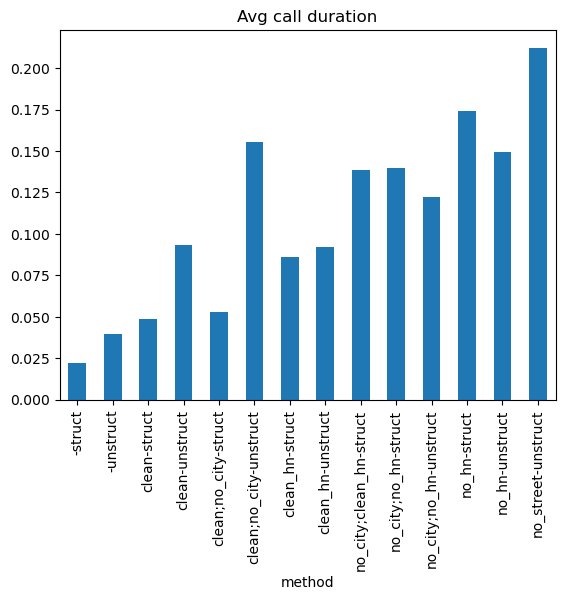

In [115]:
(addresses_seq.groupby("method").time.mean()).plot.bar(title="Avg call duration")

<Axes: >

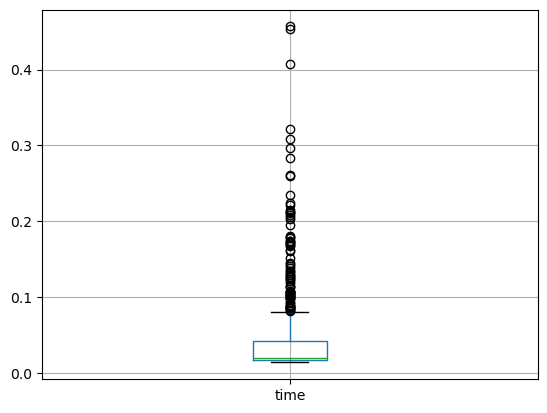

In [116]:

addresses_seq[["time"]].boxplot()

### Using Dask

In [117]:
addresses_dask = addresses.copy()

In [118]:
t = datetime.now()
dd_addresses = dd.from_pandas(addresses_dask.fillna(""), npartitions=32)

dask_task = dd_addresses[[street_field, housenbr_field, postcode_field, city_field]].apply(call_ws, meta=('x', 'str'), axis=1)

with ProgressBar(): 
    addresses_dask["json"] = dask_task.compute()
    

tot_time = (datetime.now() - t).total_seconds()

ips=addresses_dask.shape[0]/tot_time
iter_per_sec_stats["dask"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s, {ips*3600:.0f} it/h")


[########################################] | 100% Completed | 12.63 s
12.65 seconds, 79.04 it/s, 284539 it/h


In [119]:
# addresses_dask["best_id"] = addresses_dask.json.apply(lambda r: r["features"][0]["properties"]["id"] if r and len(r["features"])>0 else None )
addresses_dask["best_id"] = addresses_dask.json.apply(lambda r: get(r, ["items", 0, "bestId"]) or\
                                                              get(r, ["items", 0, "street", "id"]) or\
                                                              get(r, ["items", 0, "municipality", "id"]))

addresses_dask

,streetName,houseNumber,postCode,postName,json,best_id
0,Dendermondsesteenweg,200,2830,Willebroek,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/391785/202...
1,Boulevard du Régent,47,1000,Bruxelles,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://databrussels.be/id/address/164117/6
2,Hauwaart,44,9700,Oudenaarde,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1216986/20...
3,Bruynebosstraat,40,3511,Hasselt,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/30693367/2...
4,Steenwinkelstraat,583,2627,Schelle,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1167407/20...
...,...,...,...,...,...,...
995,Route de Marche,43,6940,Durbuy,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Address/177216/3
996,Godfried van Leuvenlaan,8,1600,Sint-Pieters-Leeuw,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/20196254/2...
997,Valleilaan,83,3290,Diest,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1994910/20...
998,Venusstraat,2,2000,Antwerpen,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1834258/20...


In [120]:
mg = addresses_dask.drop(columns="json").merge(addresses_seq.drop(columns="json"), how="outer", indicator=True)
if mg.shape[0] == addresses.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


# Test modes

In [121]:
addresses_mode = addresses.copy()

In [122]:
for mode in ["basic", "simple", "advanced"]:
    print(mode)
    t = datetime.now()
    dd_addresses = dd.from_pandas(addresses_mode.fillna(""), npartitions=32)

    dask_task = dd_addresses[[street_field, housenbr_field, postcode_field, city_field]].apply(call_ws, meta=('x', 'str'), mode=mode, axis=1)

    with ProgressBar(): 
        addresses_mode[f"json_{mode}"] = dask_task.compute()


    tot_time = (datetime.now() - t).total_seconds()

    ips=addresses_dask.shape[0]/tot_time
    iter_per_sec_stats["dask"] = ips

    addresses_mode[f"precision_{mode}"] = addresses_mode[f"json_{mode}"].apply(lambda r: get(r, ["items", 0, "precision"])).fillna("[no result]")

    addresses_mode[f"time_{mode}"] =addresses_mode[f"json_{mode}"].apply(lambda j: j["time"] if j else None) 


    print(f"{tot_time:.2f} seconds, {ips:.2f} it/s, {ips*3600:.0f} it/h")


basic
[                                        ] | 0% Completed | 264.33 us

[########################################] | 100% Completed | 5.05 ss
5.06 seconds, 197.53 it/s, 711111 it/h
simple
[########################################] | 100% Completed | 7.36 ss
7.44 seconds, 134.41 it/s, 483863 it/h
advanced
[########################################] | 100% Completed | 13.04 s
13.20 seconds, 75.77 it/s, 272760 it/h


## Match rate

In [123]:
# addresses_mode[["precision_basic", "precision_simple", "precision_advanced"]].unstack().reset_index().groupby(["level_0", 0]).level_1.count()#[0].value_counts().plot.bar(stacked=True)

In [124]:
precision = addresses_mode[["precision_basic", "precision_simple", "precision_advanced"]].unstack().rename("precision").reset_index()#.groupby(["level_0"])[0].value_counts().unstack().plot.barh(stacked=True)
precision["precision_short"] = precision["precision"].map({
            "address":              "building",
            "address_00":           "country",
            "address_streetcenter": "street",
            "address_interpol":     "building",
            "street_interpol":      "building",
            "street_00":            "country",
            "street":               "street",
            "city":                 "city",
            "country":              "country",
        }).fillna("[no res]")
precision = precision.rename(columns={"level_0":"mode"})
precision["mode"] = precision["mode"].str.split("_").str[1]
precision

,mode,level_1,precision,precision_short
0,basic,0,address,building
1,basic,1,city,city
2,basic,2,address,building
3,basic,3,address,building
4,basic,4,city,city
...,...,...,...,...
2995,advanced,995,address,building
2996,advanced,996,address,building
2997,advanced,997,address,building
2998,advanced,998,address,building


<Axes: ylabel='mode'>

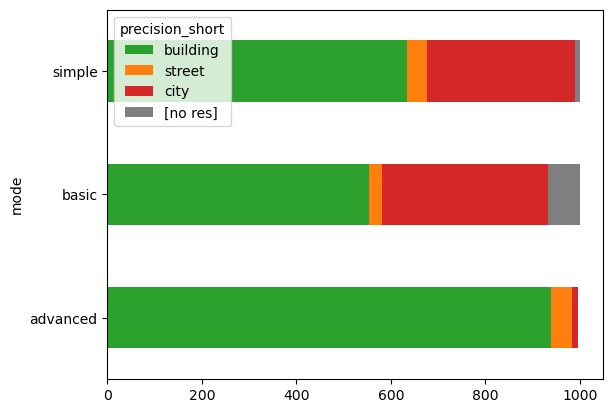

In [125]:
vc = precision.groupby(["mode"]).precision_short.value_counts().unstack()
vc = vc.reindex(["building", "street", "city", "[no res]"], axis=1)
vc.plot.barh(stacked=True, color=["tab:green", "tab:orange", "tab:red", "tab:grey"])

In [126]:
vc/addresses.shape[0]*100

precision_short,building,street,city,[no res]
mode,,,,
advanced,93.9,4.5,1.3,NaN
basic,55.3,2.9,35.0,6.8
simple,63.4,4.3,31.3,1.0


## Timing

<Axes: >

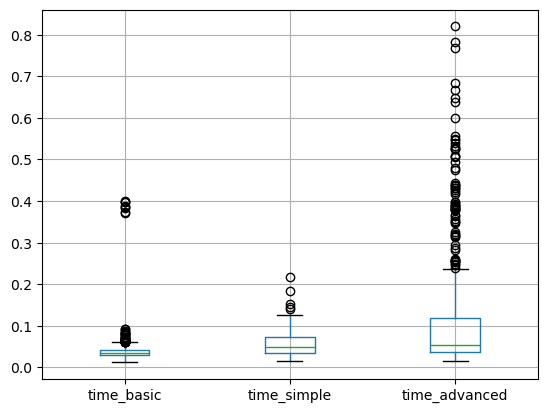

In [127]:
addresses_mode[["time_basic", "time_simple", "time_advanced"]].boxplot()

In [128]:
timing = addresses_mode[["time_basic", "time_simple", "time_advanced"]].unstack().rename("time").reset_index()
timing = timing.rename(columns={"level_0":"mode"})
timing["mode"] = timing["mode"].str.split("_").str[1]
timing

,mode,level_1,time
0,basic,0,0.045963
1,basic,1,0.032766
2,basic,2,0.036999
3,basic,3,0.051310
4,basic,4,0.025750
...,...,...,...
2995,advanced,995,0.043882
2996,advanced,996,0.021359
2997,advanced,997,0.018811
2998,advanced,998,0.020174


In [129]:
timing.groupby("mode").time.describe()

,count,mean,std,min,25%,50%,75%,max
mode,,,,,,,,
advanced,1000.0,0.097111,0.105393,0.016533,0.038040,0.054244,0.118068,0.819845
basic,1000.0,0.039620,0.033105,0.012283,0.029935,0.034834,0.042135,0.399931
simple,1000.0,0.056065,0.024994,0.015405,0.035173,0.050240,0.073542,0.217999


In [130]:
try:
    sbn.histplot(timing, x="time", hue="mode", element="poly")
except NameError:
    print("Seaborn is not installed, cannot plot this histogram")

Seaborn is not installed, cannot plot this histogram


In [131]:
addresses_mode[addresses_mode.precision_simple=="[no result]"]


,streetName,houseNumber,postCode,postName,json_basic,precision_basic,time_basic,json_simple,precision_simple,time_simple,json_advanced,precision_advanced,time_advanced
30,Oostwinkeldorp(OW),2,9931,Lievegem,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.021830,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.082683,{'self': 'http://172.27.0.64:4001/REST/bepelia...,address,0.126916
273,Avenue de Merode,54,1330,Rixensart,{'self': 'http://172.27.0.64:4001/REST/bepelia...,street,0.055756,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.072014,{'self': 'http://172.27.0.64:4001/REST/bepelia...,street_interpol,0.113118
387,Wedekensdriesstraat(KRU),5,9770,Kruisem,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.019195,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.046426,{'self': 'http://172.27.0.64:4001/REST/bepelia...,address,0.115138
488,Quai des Ardennes,135,4020,Liège,{'self': 'http://172.27.0.64:4001/REST/bepelia...,address,0.051959,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.090651,{'self': 'http://172.27.0.64:4001/REST/bepelia...,street,0.383741
728,Kaulillerweg(SHL),79,3910,Pelt,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.053464,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.056630,{'self': 'http://172.27.0.64:4001/REST/bepelia...,address,0.129293
774,"Saint-Pierre,Sous le Pont",6,6800,Libramont-Chevigny,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.020324,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.094343,{'self': 'http://172.27.0.64:4001/REST/bepelia...,city,0.507002
776,Krijgsbaan,7,2100,Antwerpen,{'self': 'http://172.27.0.64:4001/REST/bepelia...,address,0.034263,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.088603,{'self': 'http://172.27.0.64:4001/REST/bepelia...,street,0.389575
827,Rue du Raimbaix(A),4,7387,Honnelles,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.014953,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.112203,{'self': 'http://172.27.0.64:4001/REST/bepelia...,address,0.205155
959,"Neuvillers,Rue de Grandvoir",32,6800,Libramont-Chevigny,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.019192,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.102782,{'self': 'http://172.27.0.64:4001/REST/bepelia...,city,0.527699
971,Avenue Air Marshal Coningham,2,1050,Ixelles,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.012283,{'self': 'http://172.27.0.64:4001/REST/bepelia...,[no result],0.071327,{'self': 'http://172.27.0.64:4001/REST/bepelia...,street_00,0.317715


In [132]:
addresses_mode.json_basic.apply(lambda x: x["peliasRaw"]["features"][0]["properties"]["source"] if len(x["peliasRaw"]["features"])>0 else "NONE").value_counts()

# res

be-vlg           471
whosonfirst      350
be-wal            87
NONE              68
openstreetmap     13
mixed             11
Name: json_basic, dtype: int64

In [133]:
addresses_mode.json_simple.apply(lambda x: x["peliasRaw"]["features"][0]["properties"]["source"] if len(x["peliasRaw"]["features"])>0 else "NONE").value_counts()

be-vlg           502
whosonfirst      313
be-wal            97
be-bru            52
openstreetmap     14
mixed             12
NONE              10
Name: json_simple, dtype: int64

In [134]:
addresses_mode.json_advanced.apply(lambda x: x["peliasRaw"]["features"][0]["properties"]["source"] if len(x["peliasRaw"]["features"])>0 else "NONE").value_counts()

be-vlg                 612
be-wal                 249
be-bru                  93
mixed                   18
openstreetmap           17
whosonfirst              9
be-vlg-emptystreets      1
be-bru-emptystreets      1
Name: json_advanced, dtype: int64

# Get By ID

In [135]:
addresses_seq["json_from_id"] = addresses_seq["best_id"].progress_apply(call_ws_by_id)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 147.73it/s]


In [136]:
addresses_seq["json_from_id"]

0      {'self': 'http://172.27.0.64:4001/REST/bepelia...
1      {'self': 'http://172.27.0.64:4001/REST/bepelia...
2      {'self': 'http://172.27.0.64:4001/REST/bepelia...
3      {'self': 'http://172.27.0.64:4001/REST/bepelia...
4      {'self': 'http://172.27.0.64:4001/REST/bepelia...
                             ...                        
995    {'self': 'http://172.27.0.64:4001/REST/bepelia...
996    {'self': 'http://172.27.0.64:4001/REST/bepelia...
997    {'self': 'http://172.27.0.64:4001/REST/bepelia...
998    {'self': 'http://172.27.0.64:4001/REST/bepelia...
999    {'self': 'http://172.27.0.64:4001/REST/bepelia...
Name: json_from_id, Length: 1000, dtype: object

In [137]:
x = addresses_seq.json_from_id.apply(lambda r: get(r, ["items", 0, "bestId"]) or \
                                               get(r, ["items", 0, "street", "id"]) or \
                                               get(r, ["items", 0, "municipality", "id"]))


In [138]:
addresses_seq[addresses_seq.best_id != x]

,streetName,houseNumber,postCode,postName,json,best_id,time,method,json_from_id
86,Rue de Beauraing,44,5500,Dinant,{'self': 'http://172.27.0.64:4001/REST/bepelia...,None,0.142973,-struct,None
98,"Marche, Rue Porte Basse",11,6900,Marche-en-Famenne,{'self': 'http://172.27.0.64:4001/REST/bepelia...,None,0.223493,-struct,None
111,Marktplein Res. De Wijngaard,1D,3400,Landen,{'self': 'http://172.27.0.64:4001/REST/bepelia...,None,0.261461,-struct,None
135,Lindestraat,20,3840,Borgloon,{'self': 'http://172.27.0.64:4001/REST/bepelia...,None,0.168234,-struct,None
332,"Marche, Place aux Foires",9,6900,Marche-en-Famenne,{'self': 'http://172.27.0.64:4001/REST/bepelia...,None,0.210676,-struct,None
643,Bruwaenestraat,4,8750,Wingene,{'self': 'http://172.27.0.64:4001/REST/bepelia...,None,0.102581,-struct,None
769,Route de Liège,259/B,4720,Kelmis,{'self': 'http://172.27.0.64:4001/REST/bepelia...,None,0.203393,-struct,None
780,Tonny,78,6680,Sainte-Ode,{'self': 'http://172.27.0.64:4001/REST/bepelia...,None,0.103079,-struct,None
847,Sint-Lambertusstraat,4,3730,Hoeselt,{'self': 'http://172.27.0.64:4001/REST/bepelia...,None,0.173496,-struct,None


# Search city

In [139]:
addresses_seq.postCode.progress_apply(lambda r: call_ws_search_city(postcode=r))

100%|██████████| 1000/1000 [00:06<00:00, 163.82it/s]


0      {'self': 'http://172.27.0.64:4001/REST/bepelia...
1      {'self': 'http://172.27.0.64:4001/REST/bepelia...
2      {'self': 'http://172.27.0.64:4001/REST/bepelia...
3      {'self': 'http://172.27.0.64:4001/REST/bepelia...
4      {'self': 'http://172.27.0.64:4001/REST/bepelia...
                             ...                        
995    {'self': 'http://172.27.0.64:4001/REST/bepelia...
996    {'self': 'http://172.27.0.64:4001/REST/bepelia...
997    {'self': 'http://172.27.0.64:4001/REST/bepelia...
998    {'self': 'http://172.27.0.64:4001/REST/bepelia...
999    {'self': 'http://172.27.0.64:4001/REST/bepelia...
Name: postCode, Length: 1000, dtype: object

In [140]:
addresses_seq.postName.progress_apply(lambda r: call_ws_search_city(postname=r))

100%|██████████| 1000/1000 [00:10<00:00, 99.34it/s]


0      {'self': 'http://172.27.0.64:4001/REST/bepelia...
1      {'self': 'http://172.27.0.64:4001/REST/bepelia...
2      {'self': 'http://172.27.0.64:4001/REST/bepelia...
3      {'self': 'http://172.27.0.64:4001/REST/bepelia...
4      {'self': 'http://172.27.0.64:4001/REST/bepelia...
                             ...                        
995    {'self': 'http://172.27.0.64:4001/REST/bepelia...
996    {'self': 'http://172.27.0.64:4001/REST/bepelia...
997    {'self': 'http://172.27.0.64:4001/REST/bepelia...
998    {'self': 'http://172.27.0.64:4001/REST/bepelia...
999    {'self': 'http://172.27.0.64:4001/REST/bepelia...
Name: postName, Length: 1000, dtype: object

In [141]:
addresses_seq.progress_apply(lambda r: call_ws_search_city(postname=r.postName, postcode=r.postCode), axis=1)

100%|██████████| 1000/1000 [00:05<00:00, 168.58it/s]


0      {'self': 'http://172.27.0.64:4001/REST/bepelia...
1      {'self': 'http://172.27.0.64:4001/REST/bepelia...
2      {'self': 'http://172.27.0.64:4001/REST/bepelia...
3      {'self': 'http://172.27.0.64:4001/REST/bepelia...
4      {'self': 'http://172.27.0.64:4001/REST/bepelia...
                             ...                        
995    {'self': 'http://172.27.0.64:4001/REST/bepelia...
996    {'self': 'http://172.27.0.64:4001/REST/bepelia...
997    {'self': 'http://172.27.0.64:4001/REST/bepelia...
998    {'self': 'http://172.27.0.64:4001/REST/bepelia...
999    {'self': 'http://172.27.0.64:4001/REST/bepelia...
Length: 1000, dtype: object

# Reverse

In [142]:
addresses_seq["json_from_reverse"] = addresses_seq.json.progress_apply(lambda r: call_ws_reverse(**get(r, ["items", 0, "coordinates"])))

100%|██████████| 1000/1000 [00:12<00:00, 82.29it/s]


In [143]:
addresses_seq

,streetName,houseNumber,postCode,postName,json,best_id,time,method,json_from_id,json_from_reverse
0,Dendermondsesteenweg,200,2830,Willebroek,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/391785/202...,0.029295,-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...
1,Boulevard du Régent,47,1000,Bruxelles,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://databrussels.be/id/address/164117/6,0.043998,-unstruct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...
2,Hauwaart,44,9700,Oudenaarde,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1216986/20...,0.024605,-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...
3,Bruynebosstraat,40,3511,Hasselt,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/30693367/2...,0.018799,-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...
4,Steenwinkelstraat,583,2627,Schelle,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1167407/20...,0.051390,clean;no_city-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...
...,...,...,...,...,...,...,...,...,...,...
995,Route de Marche,43,6940,Durbuy,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Address/177216/3,0.040689,clean;no_city-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...
996,Godfried van Leuvenlaan,8,1600,Sint-Pieters-Leeuw,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/20196254/2...,0.018169,-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...
997,Valleilaan,83,3290,Diest,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1994910/20...,0.017208,-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...
998,Venusstraat,2,2000,Antwerpen,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1834258/20...,0.016362,-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...


In [144]:
addresses_seq["best_id_from_reverse"] = addresses_seq.json_from_reverse.apply(lambda r: get(r, ["items", 0, "bestId"]) or\
                                                              get(r, ["items", 0, "street", "id"]) or\
                                                              get(r, ["items", 0, "municipality", "id"]))

addresses_seq

,streetName,houseNumber,postCode,postName,json,best_id,time,method,json_from_id,json_from_reverse,best_id_from_reverse
0,Dendermondsesteenweg,200,2830,Willebroek,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/391785/202...,0.029295,-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/391785/202...
1,Boulevard du Régent,47,1000,Bruxelles,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://databrussels.be/id/address/164117/6,0.043998,-unstruct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://databrussels.be/id/address/164117/6
2,Hauwaart,44,9700,Oudenaarde,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1216986/20...,0.024605,-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1216986/20...
3,Bruynebosstraat,40,3511,Hasselt,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/30693367/2...,0.018799,-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/30693367/2...
4,Steenwinkelstraat,583,2627,Schelle,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1167407/20...,0.051390,clean;no_city-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1167407/20...
...,...,...,...,...,...,...,...,...,...,...,...
995,Route de Marche,43,6940,Durbuy,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Address/177216/3,0.040689,clean;no_city-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Address/177216/3
996,Godfried van Leuvenlaan,8,1600,Sint-Pieters-Leeuw,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/20196254/2...,0.018169,-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/20196254/2...
997,Valleilaan,83,3290,Diest,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1994910/20...,0.017208,-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1994910/20...
998,Venusstraat,2,2000,Antwerpen,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1834258/20...,0.016362,-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1834258/20...


In [145]:
# Mismatch OK if:
# - primary result (in json) if not "address" level (streetname, city...)
# - coordinates are interpolated (precision='address_streetcenter', 'address_interpol', ...)
# - best_id is null (and by chance we find an Best address in the coordinates given by WhosOnFirst)
# - several addresses with the same coordinates

addresses_seq[addresses_seq.best_id != addresses_seq.best_id_from_reverse]#.iloc[0:60]

,streetName,houseNumber,postCode,postName,json,best_id,time,method,json_from_id,json_from_reverse,best_id_from_reverse
12,Rue du Panorama - ATHUS,28,6791,Aubange,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Streetname/7742084/2,0.453470,clean;no_city-unstruct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,None
45,Rue Marconi,143,1190,Forest,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://databrussels.be/id/streetname/113/2,0.140661,clean;no_city-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://databrussels.be/id/address/70221/6
47,Kattenstraat,33,8800,Roeselare,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/straatnaam/58052...,0.027425,-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,None
48,Kaardeloodstraat,6,9400,Ninove,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/straatnaam/63526...,0.024432,-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/432717/202...
51,Route d' Aubel,69,4890,Thimister-Clermont,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Address/1506582/2,0.082995,clean;no_city-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,None
...,...,...,...,...,...,...,...,...,...,...,...
961,Chaussée de Bruxelles,467B,1410,Waterloo,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Streetname/7704303/6,0.030850,-unstruct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Address/89650/2
971,Avenue Air Marshal Coningham,2,1050,Ixelles,{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://databrussels.be/id/streetname/3827/2,0.099323,no_hn-unstruct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Address/1369626/2
981,Avenue Alexandre Duchesne,/,4802,Verviers,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Streetname/7738572/2,0.162198,-struct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Address/1312090/5
989,Rue Combattants(Haul),20,7120,Estinnes,{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Address/811361/1,0.126241,clean-unstruct,{'self': 'http://172.27.0.64:4001/REST/bepelia...,{'self': 'http://172.27.0.64:4001/REST/bepelia...,None


# Unstructured mode

In [146]:
addresses_unstruct = addresses.copy()

addresses_unstruct["address"] = addresses_unstruct.streetName+", " +addresses_unstruct.houseNumber + ", "+addresses_unstruct.postCode.astype(str)+" "+addresses_unstruct.postName

t = datetime.now()
addresses_unstruct["json"] = addresses_unstruct[["address"]].fillna("").progress_apply(call_unstruct_ws,
                                                                mode="advanced", axis=1)
tot_time = (datetime.now() - t).total_seconds()

ips=addresses_unstruct.shape[0]/tot_time
iter_per_sec_stats["unstruct"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")


addresses_unstruct

100%|██████████| 1000/1000 [00:43<00:00, 22.96it/s]


43.56 seconds, 22.96 it/s


,streetName,houseNumber,postCode,postName,address,json
0,Dendermondsesteenweg,200,2830,Willebroek,"Dendermondsesteenweg, 200, 2830 Willebroek",{'self': 'http://172.27.0.64:4001/REST/bepelia...
1,Boulevard du Régent,47,1000,Bruxelles,"Boulevard du Régent, 47, 1000 Bruxelles",{'self': 'http://172.27.0.64:4001/REST/bepelia...
2,Hauwaart,44,9700,Oudenaarde,"Hauwaart, 44, 9700 Oudenaarde",{'self': 'http://172.27.0.64:4001/REST/bepelia...
3,Bruynebosstraat,40,3511,Hasselt,"Bruynebosstraat, 40, 3511 Hasselt",{'self': 'http://172.27.0.64:4001/REST/bepelia...
4,Steenwinkelstraat,583,2627,Schelle,"Steenwinkelstraat, 583, 2627 Schelle",{'self': 'http://172.27.0.64:4001/REST/bepelia...
...,...,...,...,...,...,...
995,Route de Marche,43,6940,Durbuy,"Route de Marche, 43, 6940 Durbuy",{'self': 'http://172.27.0.64:4001/REST/bepelia...
996,Godfried van Leuvenlaan,8,1600,Sint-Pieters-Leeuw,"Godfried van Leuvenlaan, 8, 1600 Sint-Pieters-...",{'self': 'http://172.27.0.64:4001/REST/bepelia...
997,Valleilaan,83,3290,Diest,"Valleilaan, 83, 3290 Diest",{'self': 'http://172.27.0.64:4001/REST/bepelia...
998,Venusstraat,2,2000,Antwerpen,"Venusstraat, 2, 2000 Antwerpen",{'self': 'http://172.27.0.64:4001/REST/bepelia...


In [147]:
addresses_unstruct["best_id"] = addresses_unstruct.json.apply(lambda r: get(r, ["items", 0, "bestId"]) or\
                                                              get(r, ["items", 0, "street", "id"]) or\
                                                              get(r, ["items", 0, "municipality", "id"]))

addresses_unstruct

,streetName,houseNumber,postCode,postName,address,json,best_id
0,Dendermondsesteenweg,200,2830,Willebroek,"Dendermondsesteenweg, 200, 2830 Willebroek",{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/391785/202...
1,Boulevard du Régent,47,1000,Bruxelles,"Boulevard du Régent, 47, 1000 Bruxelles",{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://databrussels.be/id/address/164117/6
2,Hauwaart,44,9700,Oudenaarde,"Hauwaart, 44, 9700 Oudenaarde",{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1216986/20...
3,Bruynebosstraat,40,3511,Hasselt,"Bruynebosstraat, 40, 3511 Hasselt",{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/30693367/2...
4,Steenwinkelstraat,583,2627,Schelle,"Steenwinkelstraat, 583, 2627 Schelle",{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1167407/20...
...,...,...,...,...,...,...,...
995,Route de Marche,43,6940,Durbuy,"Route de Marche, 43, 6940 Durbuy",{'self': 'http://172.27.0.64:4001/REST/bepelia...,geodata.wallonie.be/id/Address/177216/3
996,Godfried van Leuvenlaan,8,1600,Sint-Pieters-Leeuw,"Godfried van Leuvenlaan, 8, 1600 Sint-Pieters-...",{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/20196254/2...
997,Valleilaan,83,3290,Diest,"Valleilaan, 83, 3290 Diest",{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1994910/20...
998,Venusstraat,2,2000,Antwerpen,"Venusstraat, 2, 2000 Antwerpen",{'self': 'http://172.27.0.64:4001/REST/bepelia...,https://data.vlaanderen.be/id/adres/1834258/20...


In [148]:
mg = addresses_unstruct.drop(columns="json").merge(addresses_seq.drop(columns="json"), how="outer", indicator=True)

print(f"Agree on {mg[mg._merge=='both'].shape[0]}/{addresses_unstruct.shape[0]}")

Agree on 973/1000
